In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 3
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
pcmciplus_features = ['LW_down', 'sst', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[pcmciplus_features]
df.tail(len(df))

,LW_down,sst,sea_ice_extent
Date,,,
1979-01-01,186.687054,273.355237,15604191.0
1979-02-01,174.794571,273.121885,16378929.0
1979-03-01,190.741933,273.088099,16521089.0
1979-04-01,212.937925,273.126062,15561238.0
1979-05-01,253.690478,273.393551,14085613.0
...,...,...,...
2021-04-01,225.171796,273.470298,13840000.0
2021-05-01,260.956781,273.888627,12660000.0
2021-06-01,294.931709,275.245088,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

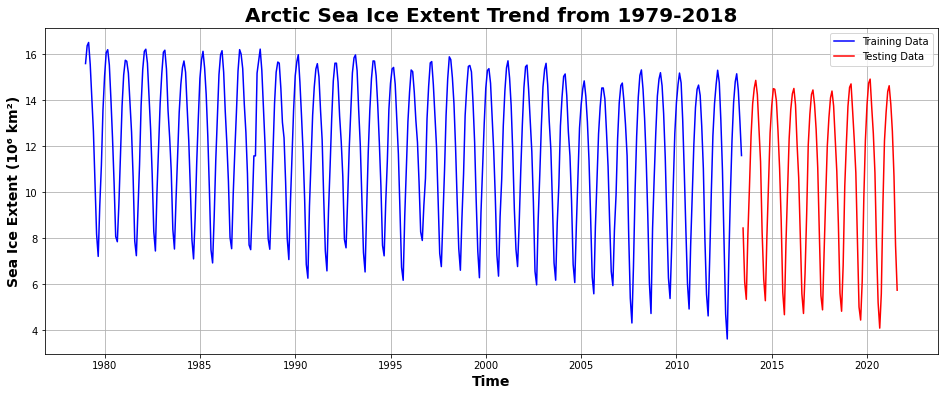

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13248     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.0801 - mae: 0.7585 - mse: 1.0801

6/6 [==============================] - 18s 526ms/step - loss: 1.0801 - mae: 0.7585 - mse: 1.0801 - val_loss: 0.3013 - val_mae: 0.4827 - val_mse: 0.3013
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1984 - mae: 0.3720 - mse: 0.1984

6/6 [==============================] - 0s 56ms/step - loss: 0.2039 - mae: 0.3770 - mse: 0.2039 - val_loss: 0.1228 - val_mae: 0.2528 - val_mse: 0.1228
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0809 - mae: 0.2362 - mse: 0.0809

6/6 [==============================] - 0s 45ms/step - loss: 0.0820 - mae: 0.2384 - mse: 0.0820 - val_loss: 0.0750 - val_mae: 0.2329 - val_mse: 0.0750
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0609 - mae: 0.2018 - mse: 0.0609

6/6 [==============================] - 0s 44ms/step - loss: 0.0591 - mae: 0.1977 - mse: 0.0591 - val_loss: 0.0665 - val_mae: 0.2198 - val_mse: 0.0665
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0528 - mae: 0.1972 - mse: 0.0528

6/6 [==============================] - 0s 44ms/step - loss: 0.0528 - mae: 0.1960 - mse: 0.0528 - val_loss: 0.0663 - val_mae: 0.1853 - val_mse: 0.0663
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0455 - mae: 0.1696 - mse: 0.0455

6/6 [==============================] - 0s 45ms/step - loss: 0.0449 - mae: 0.1695 - mse: 0.0449 - val_loss: 0.0561 - val_mae: 0.1735 - val_mse: 0.0561
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0360 - mae: 0.1583 - mse: 0.0360

6/6 [==============================] - 0s 46ms/step - loss: 0.0361 - mae: 0.1586 - mse: 0.0361 - val_loss: 0.0930 - val_mae: 0.2189 - val_mse: 0.0930
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0399 - mae: 0.1559 - mse: 0.0399

6/6 [==============================] - 0s 44ms/step - loss: 0.0391 - mae: 0.1554 - mse: 0.0391 - val_loss: 0.0442 - val_mae: 0.1552 - val_mse: 0.0442
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0233 - mae: 0.1173 - mse: 0.0233

6/6 [==============================] - 0s 44ms/step - loss: 0.0233 - mae: 0.1168 - mse: 0.0233 - val_loss: 0.0326 - val_mae: 0.1275 - val_mse: 0.0326
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0184 - mae: 0.1096 - mse: 0.0184

6/6 [==============================] - 0s 45ms/step - loss: 0.0180 - mae: 0.1087 - mse: 0.0180 - val_loss: 0.0700 - val_mae: 0.2164 - val_mse: 0.0700
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0187 - mae: 0.1065 - mse: 0.0187

6/6 [==============================] - 0s 47ms/step - loss: 0.0186 - mae: 0.1071 - mse: 0.0186 - val_loss: 0.0540 - val_mae: 0.2063 - val_mse: 0.0540
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0181 - mae: 0.1015 - mse: 0.0181

6/6 [==============================] - 0s 44ms/step - loss: 0.0178 - mae: 0.1016 - mse: 0.0178 - val_loss: 0.0260 - val_mae: 0.1107 - val_mse: 0.0260
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0120 - mae: 0.0846 - mse: 0.0120

6/6 [==============================] - 0s 46ms/step - loss: 0.0127 - mae: 0.0863 - mse: 0.0127 - val_loss: 0.0291 - val_mae: 0.1231 - val_mse: 0.0291
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0109 - mae: 0.0843 - mse: 0.0109

6/6 [==============================] - 0s 46ms/step - loss: 0.0115 - mae: 0.0856 - mse: 0.0115 - val_loss: 0.0275 - val_mae: 0.1148 - val_mse: 0.0275
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0114 - mae: 0.0831 - mse: 0.0114

6/6 [==============================] - 0s 46ms/step - loss: 0.0113 - mae: 0.0830 - mse: 0.0113 - val_loss: 0.0238 - val_mae: 0.1262 - val_mse: 0.0238
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0094 - mae: 0.0755 - mse: 0.0094

6/6 [==============================] - 0s 45ms/step - loss: 0.0094 - mae: 0.0760 - mse: 0.0094 - val_loss: 0.0278 - val_mae: 0.1272 - val_mse: 0.0278
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0119 - mae: 0.0827 - mse: 0.0119

6/6 [==============================] - 0s 45ms/step - loss: 0.0115 - mae: 0.0816 - mse: 0.0115 - val_loss: 0.0178 - val_mae: 0.0979 - val_mse: 0.0178
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0094 - mae: 0.0748 - mse: 0.0094

6/6 [==============================] - 0s 45ms/step - loss: 0.0093 - mae: 0.0751 - mse: 0.0093 - val_loss: 0.0133 - val_mae: 0.0715 - val_mse: 0.0133
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0088 - mae: 0.0719 - mse: 0.0088

6/6 [==============================] - 0s 44ms/step - loss: 0.0088 - mae: 0.0710 - mse: 0.0088 - val_loss: 0.0081 - val_mae: 0.0512 - val_mse: 0.0081
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0097 - mae: 0.0767 - mse: 0.0097

6/6 [==============================] - 0s 44ms/step - loss: 0.0095 - mae: 0.0757 - mse: 0.0095 - val_loss: 0.0134 - val_mae: 0.0782 - val_mse: 0.0134
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0080 - mae: 0.0702 - mse: 0.0080

6/6 [==============================] - 0s 43ms/step - loss: 0.0078 - mae: 0.0692 - mse: 0.0078 - val_loss: 0.0189 - val_mae: 0.0940 - val_mse: 0.0189
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0077 - mae: 0.0676 - mse: 0.0077

6/6 [==============================] - 0s 44ms/step - loss: 0.0076 - mae: 0.0670 - mse: 0.0076 - val_loss: 0.0098 - val_mae: 0.0701 - val_mse: 0.0098
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0076 - mae: 0.0689 - mse: 0.0076

6/6 [==============================] - 0s 44ms/step - loss: 0.0083 - mae: 0.0711 - mse: 0.0083 - val_loss: 0.0113 - val_mae: 0.0711 - val_mse: 0.0113
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0093 - mae: 0.0746 - mse: 0.0093

6/6 [==============================] - 0s 46ms/step - loss: 0.0093 - mae: 0.0743 - mse: 0.0093 - val_loss: 0.0054 - val_mae: 0.0419 - val_mse: 0.0054
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0067 - mae: 0.0633 - mse: 0.0067

6/6 [==============================] - 0s 46ms/step - loss: 0.0069 - mae: 0.0639 - mse: 0.0069 - val_loss: 0.0122 - val_mae: 0.0737 - val_mse: 0.0122
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0071 - mae: 0.0666 - mse: 0.0071

6/6 [==============================] - 0s 46ms/step - loss: 0.0071 - mae: 0.0663 - mse: 0.0071 - val_loss: 0.0190 - val_mae: 0.1041 - val_mse: 0.0190
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0670 - mse: 0.0072

6/6 [==============================] - 0s 45ms/step - loss: 0.0069 - mae: 0.0655 - mse: 0.0069 - val_loss: 0.0201 - val_mae: 0.1083 - val_mse: 0.0201
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0078 - mae: 0.0706 - mse: 0.0078

6/6 [==============================] - 0s 43ms/step - loss: 0.0076 - mae: 0.0691 - mse: 0.0076 - val_loss: 0.0177 - val_mae: 0.1024 - val_mse: 0.0177
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0078 - mae: 0.0700 - mse: 0.0078

6/6 [==============================] - 0s 45ms/step - loss: 0.0077 - mae: 0.0693 - mse: 0.0077 - val_loss: 0.0143 - val_mae: 0.0970 - val_mse: 0.0143
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0632 - mse: 0.0064

6/6 [==============================] - 0s 46ms/step - loss: 0.0063 - mae: 0.0630 - mse: 0.0063 - val_loss: 0.0057 - val_mae: 0.0506 - val_mse: 0.0057
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0680 - mse: 0.0074

6/6 [==============================] - 0s 45ms/step - loss: 0.0073 - mae: 0.0677 - mse: 0.0073 - val_loss: 0.0030 - val_mae: 0.0376 - val_mse: 0.0030
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0084 - mae: 0.0687 - mse: 0.0084

6/6 [==============================] - 0s 45ms/step - loss: 0.0084 - mae: 0.0695 - mse: 0.0084 - val_loss: 0.0047 - val_mae: 0.0532 - val_mse: 0.0047
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0076 - mae: 0.0707 - mse: 0.0076

6/6 [==============================] - 0s 46ms/step - loss: 0.0074 - mae: 0.0698 - mse: 0.0074 - val_loss: 0.0044 - val_mae: 0.0402 - val_mse: 0.0044
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0652 - mse: 0.0070

6/6 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.0650 - mse: 0.0069 - val_loss: 0.0069 - val_mae: 0.0574 - val_mse: 0.0069
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0581 - mse: 0.0053

6/6 [==============================] - 0s 45ms/step - loss: 0.0053 - mae: 0.0585 - mse: 0.0053 - val_loss: 0.0068 - val_mae: 0.0552 - val_mse: 0.0068
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0512 - mse: 0.0044

6/6 [==============================] - 0s 44ms/step - loss: 0.0043 - mae: 0.0514 - mse: 0.0043 - val_loss: 0.0052 - val_mae: 0.0442 - val_mse: 0.0052
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0509 - mse: 0.0041

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0524 - mse: 0.0043 - val_loss: 0.0040 - val_mae: 0.0425 - val_mse: 0.0040
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0528 - mse: 0.0045

6/6 [==============================] - 0s 46ms/step - loss: 0.0044 - mae: 0.0525 - mse: 0.0044 - val_loss: 0.0030 - val_mae: 0.0360 - val_mse: 0.0030
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0514 - mse: 0.0042

6/6 [==============================] - 0s 46ms/step - loss: 0.0041 - mae: 0.0513 - mse: 0.0041 - val_loss: 0.0033 - val_mae: 0.0359 - val_mse: 0.0033
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0514 - mse: 0.0043

6/6 [==============================] - 0s 48ms/step - loss: 0.0042 - mae: 0.0506 - mse: 0.0042 - val_loss: 0.0026 - val_mae: 0.0357 - val_mse: 0.0026
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0514 - mse: 0.0043

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0507 - mse: 0.0041 - val_loss: 0.0029 - val_mae: 0.0423 - val_mse: 0.0029
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0488 - mse: 0.0038

6/6 [==============================] - 0s 46ms/step - loss: 0.0039 - mae: 0.0498 - mse: 0.0039 - val_loss: 0.0032 - val_mae: 0.0417 - val_mse: 0.0032
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0485 - mse: 0.0038

6/6 [==============================] - 0s 46ms/step - loss: 0.0037 - mae: 0.0481 - mse: 0.0037 - val_loss: 0.0024 - val_mae: 0.0338 - val_mse: 0.0024
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0484 - mse: 0.0039

6/6 [==============================] - 0s 44ms/step - loss: 0.0039 - mae: 0.0487 - mse: 0.0039 - val_loss: 0.0027 - val_mae: 0.0403 - val_mse: 0.0027
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0521 - mse: 0.0043

6/6 [==============================] - 0s 46ms/step - loss: 0.0042 - mae: 0.0521 - mse: 0.0042 - val_loss: 0.0048 - val_mae: 0.0524 - val_mse: 0.0048
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0494 - mse: 0.0042

6/6 [==============================] - 0s 45ms/step - loss: 0.0041 - mae: 0.0492 - mse: 0.0041 - val_loss: 0.0030 - val_mae: 0.0436 - val_mse: 0.0030
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0497 - mse: 0.0037

6/6 [==============================] - 0s 47ms/step - loss: 0.0038 - mae: 0.0498 - mse: 0.0038 - val_loss: 0.0025 - val_mae: 0.0397 - val_mse: 0.0025
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0463 - mse: 0.0033

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0466 - mse: 0.0034 - val_loss: 0.0032 - val_mae: 0.0473 - val_mse: 0.0032
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0487 - mse: 0.0038

6/6 [==============================] - 0s 45ms/step - loss: 0.0038 - mae: 0.0486 - mse: 0.0038 - val_loss: 0.0033 - val_mae: 0.0437 - val_mse: 0.0033
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0516 - mse: 0.0041

6/6 [==============================] - 0s 46ms/step - loss: 0.0041 - mae: 0.0513 - mse: 0.0041 - val_loss: 0.0042 - val_mae: 0.0449 - val_mse: 0.0042
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0502 - mse: 0.0038

6/6 [==============================] - 0s 45ms/step - loss: 0.0040 - mae: 0.0511 - mse: 0.0040 - val_loss: 0.0032 - val_mae: 0.0385 - val_mse: 0.0032
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0494 - mse: 0.0040

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0509 - mse: 0.0043 - val_loss: 0.0035 - val_mae: 0.0462 - val_mse: 0.0035
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0473 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0035 - mae: 0.0473 - mse: 0.0035 - val_loss: 0.0024 - val_mae: 0.0316 - val_mse: 0.0024
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0473 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0037 - mae: 0.0479 - mse: 0.0037 - val_loss: 0.0026 - val_mae: 0.0381 - val_mse: 0.0026
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0501 - mse: 0.0039

6/6 [==============================] - 0s 44ms/step - loss: 0.0038 - mae: 0.0499 - mse: 0.0038 - val_loss: 0.0029 - val_mae: 0.0429 - val_mse: 0.0029
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0460 - mse: 0.0033

6/6 [==============================] - 0s 46ms/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0036 - val_mae: 0.0500 - val_mse: 0.0036
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0478 - mse: 0.0036

6/6 [==============================] - 0s 44ms/step - loss: 0.0035 - mae: 0.0471 - mse: 0.0035 - val_loss: 0.0019 - val_mae: 0.0329 - val_mse: 0.0019
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0507 - mse: 0.0040

6/6 [==============================] - 0s 45ms/step - loss: 0.0040 - mae: 0.0509 - mse: 0.0040 - val_loss: 0.0045 - val_mae: 0.0592 - val_mse: 0.0045
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0490 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0492 - mse: 0.0036 - val_loss: 0.0027 - val_mae: 0.0374 - val_mse: 0.0027
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0507 - mse: 0.0040

6/6 [==============================] - 0s 45ms/step - loss: 0.0040 - mae: 0.0507 - mse: 0.0040 - val_loss: 0.0038 - val_mae: 0.0530 - val_mse: 0.0038
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0459 - mse: 0.0031

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0461 - mse: 0.0033 - val_loss: 0.0030 - val_mae: 0.0426 - val_mse: 0.0030
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0455 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0032 - mae: 0.0458 - mse: 0.0032 - val_loss: 0.0029 - val_mae: 0.0408 - val_mse: 0.0029
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0483 - mse: 0.0038

6/6 [==============================] - 0s 44ms/step - loss: 0.0038 - mae: 0.0482 - mse: 0.0038 - val_loss: 0.0014 - val_mae: 0.0293 - val_mse: 0.0014
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0484 - mse: 0.0037

6/6 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0483 - mse: 0.0036 - val_loss: 0.0042 - val_mae: 0.0532 - val_mse: 0.0042
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0460 - mse: 0.0034

6/6 [==============================] - 0s 44ms/step - loss: 0.0033 - mae: 0.0451 - mse: 0.0033 - val_loss: 0.0019 - val_mae: 0.0319 - val_mse: 0.0019
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0419 - mse: 0.0029

6/6 [==============================] - 0s 44ms/step - loss: 0.0030 - mae: 0.0427 - mse: 0.0030 - val_loss: 0.0025 - val_mae: 0.0359 - val_mse: 0.0025
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0440 - mse: 0.0031

6/6 [==============================] - 0s 46ms/step - loss: 0.0031 - mae: 0.0437 - mse: 0.0031 - val_loss: 0.0021 - val_mae: 0.0375 - val_mse: 0.0021
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0441 - mse: 0.0031

6/6 [==============================] - 0s 44ms/step - loss: 0.0030 - mae: 0.0435 - mse: 0.0030 - val_loss: 0.0025 - val_mae: 0.0366 - val_mse: 0.0025
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0427 - mse: 0.0028

6/6 [==============================] - 0s 44ms/step - loss: 0.0027 - mae: 0.0416 - mse: 0.0027 - val_loss: 0.0025 - val_mae: 0.0421 - val_mse: 0.0025
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0419 - mse: 0.0028

6/6 [==============================] - 0s 44ms/step - loss: 0.0027 - mae: 0.0414 - mse: 0.0027 - val_loss: 0.0017 - val_mae: 0.0313 - val_mse: 0.0017
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0427 - mse: 0.0029

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0422 - mse: 0.0028 - val_loss: 0.0039 - val_mae: 0.0558 - val_mse: 0.0039
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0419 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0427 - mse: 0.0029 - val_loss: 0.0020 - val_mae: 0.0389 - val_mse: 0.0020
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0384 - mse: 0.0025

6/6 [==============================] - 0s 45ms/step - loss: 0.0025 - mae: 0.0388 - mse: 0.0025 - val_loss: 0.0028 - val_mae: 0.0437 - val_mse: 0.0028
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0426 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0029 - mae: 0.0420 - mse: 0.0029 - val_loss: 0.0031 - val_mae: 0.0440 - val_mse: 0.0031
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0448 - mse: 0.0031

6/6 [==============================] - 0s 45ms/step - loss: 0.0032 - mae: 0.0454 - mse: 0.0032 - val_loss: 0.0021 - val_mae: 0.0347 - val_mse: 0.0021
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0501 - mse: 0.0040

6/6 [==============================] - 0s 46ms/step - loss: 0.0039 - mae: 0.0496 - mse: 0.0039 - val_loss: 0.0030 - val_mae: 0.0380 - val_mse: 0.0030
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0466 - mse: 0.0034

6/6 [==============================] - 0s 46ms/step - loss: 0.0033 - mae: 0.0459 - mse: 0.0033 - val_loss: 0.0036 - val_mae: 0.0470 - val_mse: 0.0036
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0417 - mse: 0.0029

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0424 - mse: 0.0030 - val_loss: 0.0028 - val_mae: 0.0427 - val_mse: 0.0028
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0458 - mse: 0.0034

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0461 - mse: 0.0034 - val_loss: 0.0025 - val_mae: 0.0405 - val_mse: 0.0025
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0417 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0419 - mse: 0.0030 - val_loss: 0.0021 - val_mae: 0.0352 - val_mse: 0.0021
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0414 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0417 - mse: 0.0029 - val_loss: 0.0025 - val_mae: 0.0433 - val_mse: 0.0025
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0430 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0431 - mse: 0.0030 - val_loss: 0.0052 - val_mae: 0.0645 - val_mse: 0.0052
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0477 - mse: 0.0033

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0478 - mse: 0.0034 - val_loss: 0.0024 - val_mae: 0.0412 - val_mse: 0.0024
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0447 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0443 - mse: 0.0030 - val_loss: 0.0044 - val_mae: 0.0599 - val_mse: 0.0044
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0425 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0421 - mse: 0.0030 - val_loss: 0.0020 - val_mae: 0.0352 - val_mse: 0.0020
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0399 - mse: 0.0025

6/6 [==============================] - 0s 47ms/step - loss: 0.0025 - mae: 0.0401 - mse: 0.0025 - val_loss: 0.0025 - val_mae: 0.0363 - val_mse: 0.0025
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0447 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0031 - mae: 0.0442 - mse: 0.0031 - val_loss: 0.0019 - val_mae: 0.0319 - val_mse: 0.0019
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0432 - mse: 0.0029

6/6 [==============================] - 0s 45ms/step - loss: 0.0029 - mae: 0.0434 - mse: 0.0029 - val_loss: 0.0028 - val_mae: 0.0403 - val_mse: 0.0028
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0421 - mse: 0.0027

6/6 [==============================] - 0s 47ms/step - loss: 0.0027 - mae: 0.0422 - mse: 0.0027 - val_loss: 0.0021 - val_mae: 0.0335 - val_mse: 0.0021
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0405 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0399 - mse: 0.0028 - val_loss: 0.0020 - val_mae: 0.0350 - val_mse: 0.0020
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0419 - mse: 0.0029

6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - mae: 0.0424 - mse: 0.0029 - val_loss: 0.0025 - val_mae: 0.0441 - val_mse: 0.0025
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0023 - mae: 0.0389 - mse: 0.0023

6/6 [==============================] - 0s 46ms/step - loss: 0.0023 - mae: 0.0389 - mse: 0.0023 - val_loss: 0.0024 - val_mae: 0.0396 - val_mse: 0.0024
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0406 - mse: 0.0026

6/6 [==============================] - 0s 45ms/step - loss: 0.0026 - mae: 0.0403 - mse: 0.0026 - val_loss: 0.0024 - val_mae: 0.0393 - val_mse: 0.0024
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0433 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0430 - mse: 0.0029 - val_loss: 0.0013 - val_mae: 0.0257 - val_mse: 0.0013
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0461 - mse: 0.0032

6/6 [==============================] - 0s 48ms/step - loss: 0.0032 - mae: 0.0459 - mse: 0.0032 - val_loss: 0.0025 - val_mae: 0.0393 - val_mse: 0.0025
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0447 - mse: 0.0031

6/6 [==============================] - 0s 47ms/step - loss: 0.0032 - mae: 0.0455 - mse: 0.0032 - val_loss: 0.0016 - val_mae: 0.0280 - val_mse: 0.0016
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0422 - mse: 0.0028

6/6 [==============================] - 0s 46ms/step - loss: 0.0028 - mae: 0.0416 - mse: 0.0028 - val_loss: 0.0027 - val_mae: 0.0462 - val_mse: 0.0027
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0406 - mse: 0.0026

6/6 [==============================] - 0s 44ms/step - loss: 0.0026 - mae: 0.0403 - mse: 0.0026 - val_loss: 0.0017 - val_mae: 0.0324 - val_mse: 0.0017
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0424 - mse: 0.0027

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0412 - mse: 0.0026 - val_loss: 0.0021 - val_mae: 0.0372 - val_mse: 0.0021
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0022 - mae: 0.0359 - mse: 0.0022

6/6 [==============================] - 0s 46ms/step - loss: 0.0022 - mae: 0.0363 - mse: 0.0022 - val_loss: 0.0020 - val_mae: 0.0343 - val_mse: 0.0020


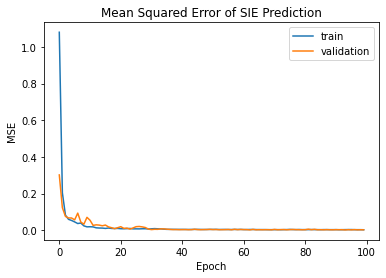

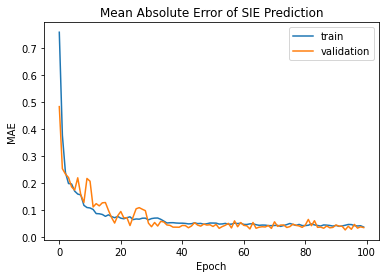

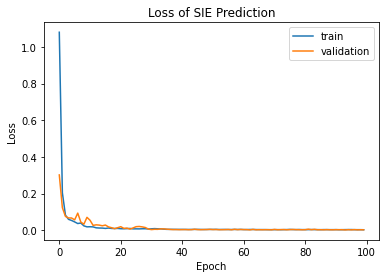

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


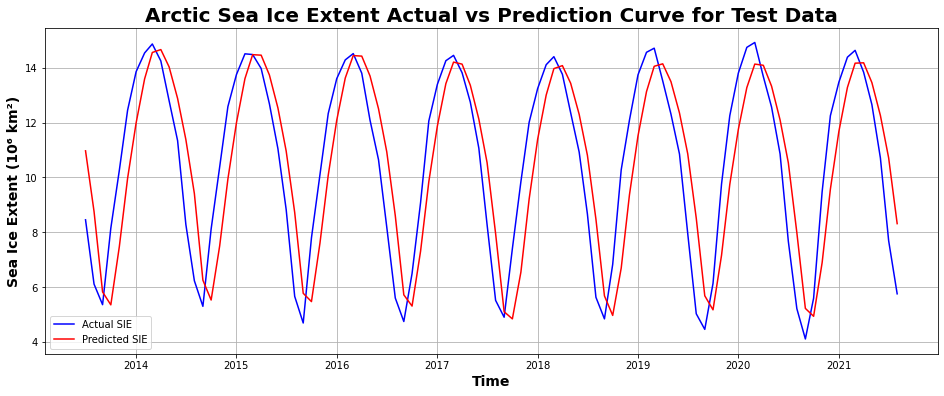

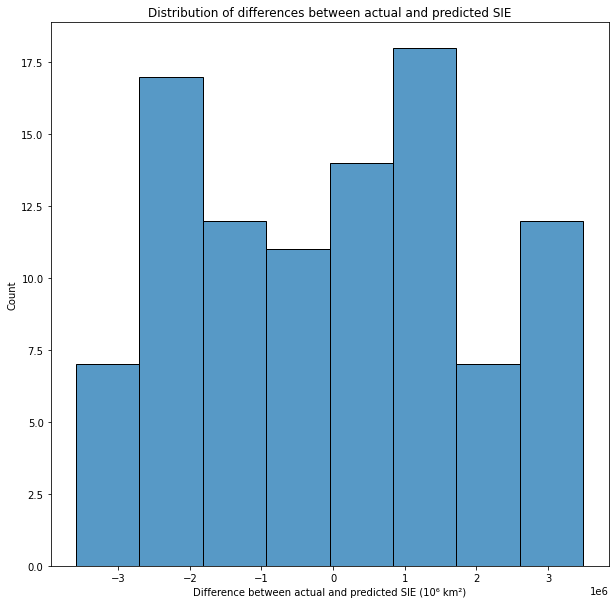

MSE :  3679790729765.5996 (10⁶ km²)
MSPE : 5.818 %
RMSE :  1918278.063724235 (10⁶ km²)
RMSPE : 24.12 %
MAE :  1668152.525510204 (10⁶ km²)
MAPE :  18.783 %
R2 :  62.516


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass